# Линейная регрессия: переобучение и регуляризация

В этом задании мы на примерах увидим, как переобучаются линейные модели, разберем, почему так происходит, и выясним, как диагностировать и контролировать переобучение.

Во всех ячейках, где написан комментарий с инструкциями, нужно написать код, выполняющий эти инструкции. Остальные ячейки с кодом (без комментариев) нужно просто выполнить. Кроме того, в задании требуется отвечать на вопросы; ответы нужно вписывать после выделенного слова "__Ответ:__".

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import seaborn as sns
%matplotlib inline

Мы будем работать с датасетом __"bikes_rent.csv"__, в котором по дням записаны календарная информация и погодные условия, характеризующие автоматизированные пункты проката велосипедов, а также число прокатов в этот день. Последнее мы будем предсказывать; таким образом, мы будем решать задачу регрессии.

### Знакомство с данными

## Задание 1

Загрузите датасет с помощью функции __pandas.read_csv__ в переменную __df__. Выведите первые 5 строчек, чтобы убедиться в корректном считывании данных:

In [2]:
df = pd.read_csv('bikes_rent.csv')

df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600


Для каждого дня проката известны следующие признаки:
* _season_: 1 - весна, 2 - лето, 3 - осень, 4 - зима
* _yr_: 0 - 2011, 1 - 2012
* _mnth_: от 1 до 12
* _holiday_: 0 - нет праздника, 1 - есть праздник
* _weekday_: от 0 до 6
* _workingday_: 0 - нерабочий день, 1 - рабочий день
* _weathersit_: оценка благоприятности погоды от 1 (чистый, ясный день) до 4 (ливень, туман)
* _temp_: температура в Цельсиях
* _atemp_: температура по ощущениям в Цельсиях
* _hum_: влажность
* _windspeed(mph)_: скорость ветра в милях в час
* _windspeed(ms)_: скорость ветра в метрах в секунду
* _cnt_: количество арендованных велосипедов (это целевой признак, его мы будем предсказывать)

Итак, у нас есть вещественные, бинарные и номинальные (порядковые) признаки, и со всеми из них можно работать как с вещественными. С номинальныеми признаками тоже можно работать как с вещественными, потому что на них задан порядок. Давайте посмотрим на графиках, как целевой признак зависит от остальных

Постройте графики зависимостей атрибутов от количества поездок. Другими словами вам нужно построить 12 графиков. На каждом должна быть изображена зависимость очередного атрибута от переменной **cnt**.

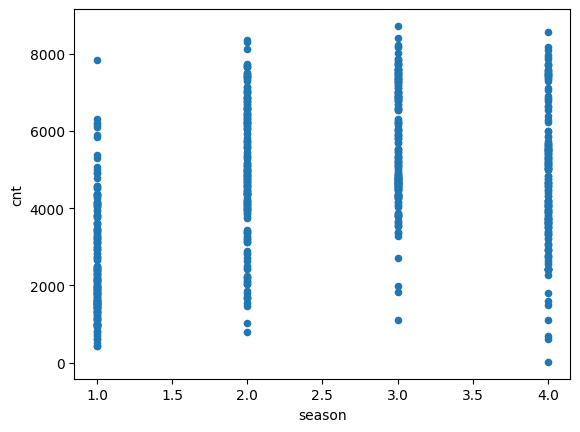

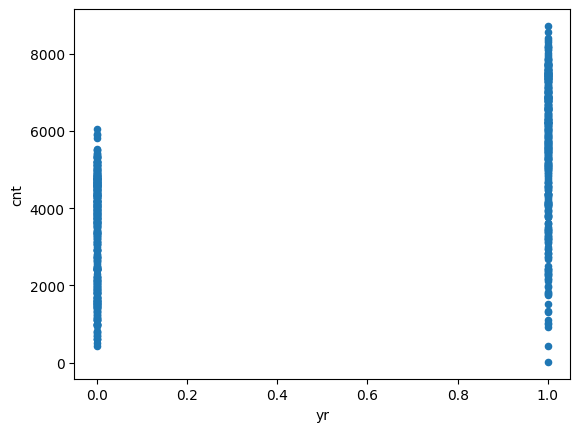

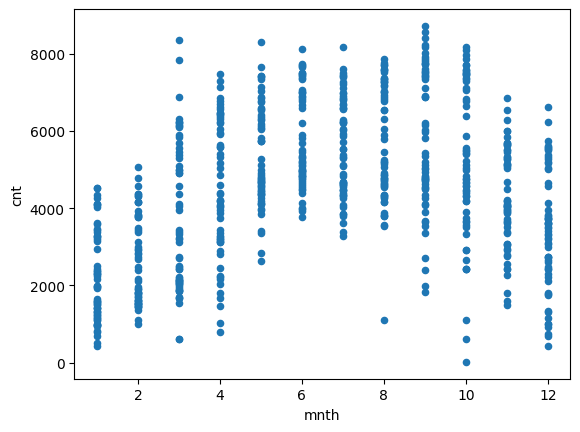

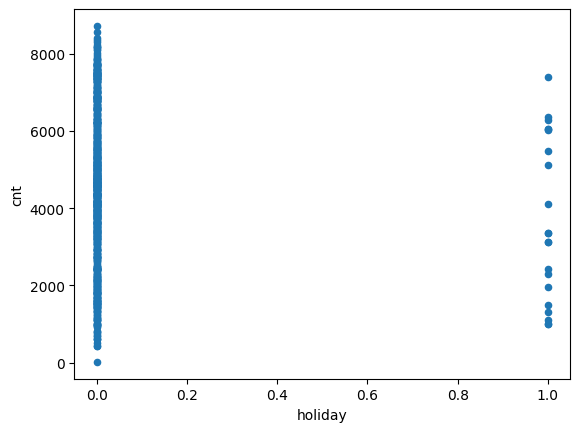

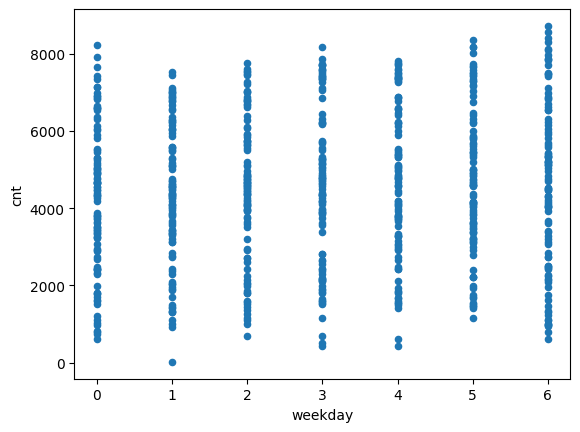

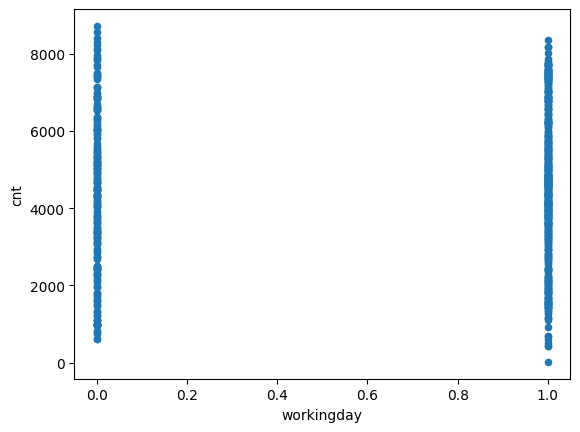

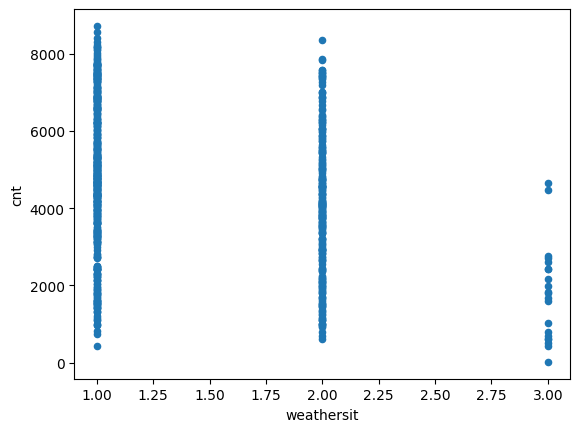

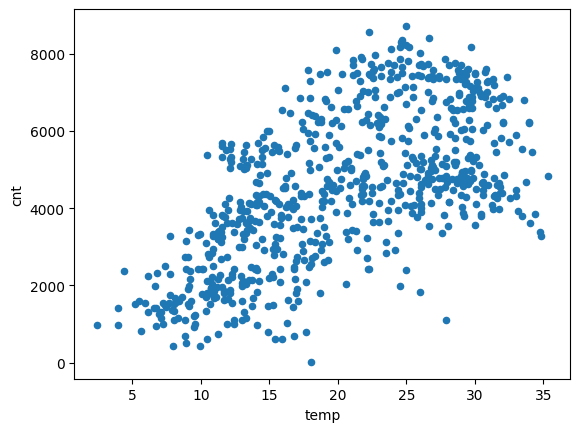

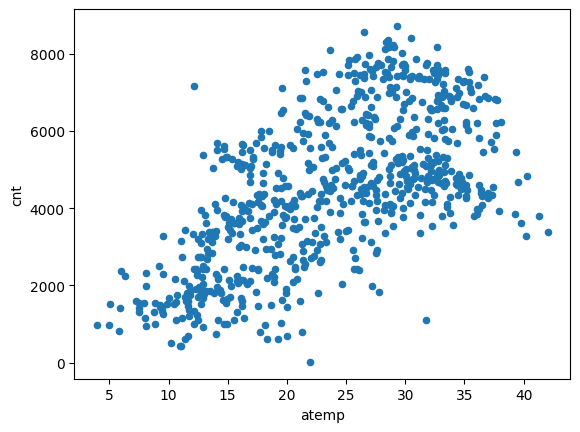

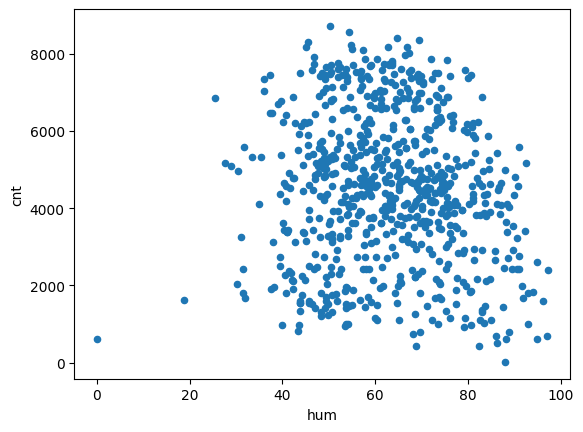

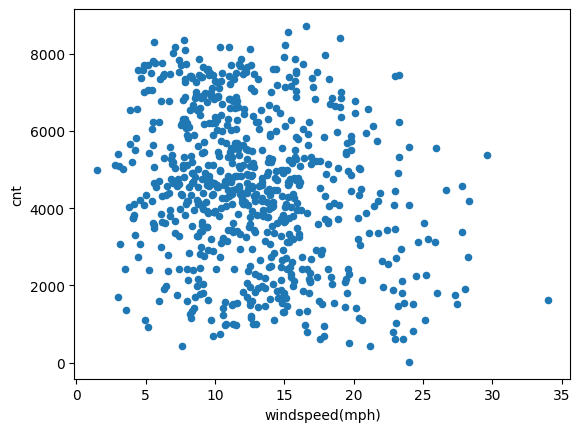

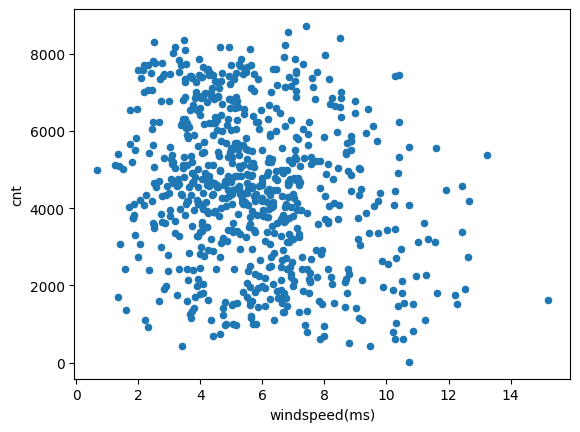

In [3]:
for column in list(df)[:-1]:

    df.plot(x=column, y = 'cnt', kind = 'scatter')
    plt.show()


__Вопросы:__
1. Каков характер зависимости числа прокатов от месяца?

Линейный

1. Укажите один или два признака, от которых число прокатов скорее всего зависит линейно

wethersit, temp and atemp, 


## Задание 2

Давайте более строго оценим уровень линейной зависимости между признаками и целевой переменной. Хорошей мерой линейной зависимости между двумя векторами является корреляция Пирсона. Нам уже приходилось иметь с ней дело раньше. Для ее вычисления в pandas можно использовать методы датафрейма: corr и corrwith.

Посчитайте корреляции всех признаков, кроме последнего, с последним с помощью метода `corrwith`.

In [4]:
print('-'*43)
print('|{:^20}|{:^20}|'.format('feature', 'corr_coef'))
print('-'*43)
for column in list(df)[:-1]:

    print('|{:<20}|{:<20}|'.format(column, df[column].corr(df['cnt'])))
    
print('-'*43)

-------------------------------------------
|      feature       |     corr_coef      |
-------------------------------------------
|season              |0.4061003707986361  |
|yr                  |0.5667097078680869  |
|mnth                |0.27997711221927113 |
|holiday             |-0.06834771589248417|
|weekday             |0.06744341241063048 |
|workingday          |0.06115606306052071 |
|weathersit          |-0.29739123883466373|
|temp                |0.6274940090334922  |
|atemp               |0.6310656998491813  |
|hum                 |-0.10065856213715518|
|windspeed(mph)      |-0.23454499742167007|
|windspeed(ms)       |-0.2345449974216893 |
-------------------------------------------


В выборке есть признаки, коррелирующие с целевым, а значит, задачу можно решать линейными методами.

По графикам видно, что некоторые признаки похожи друг на друга. Поэтому давайте также посчитаем корреляции между вещественными признаками.

## Задание 3

Посчитайте попарные корреляции между признаками temp, atemp, hum, windspeed(mph), windspeed(ms) и cnt
с помощью метода corr:

In [5]:
print('-'*73)
print('|{:<35}|{:<35}|'.format('feature1 - feature1', 'corr_coef'))
print('-'*73)



features = ['temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)', 'cnt']

i=0

for feature in features[:-1]:
    i+=1
    rest_features = features[i:]
    
    for feature1 in rest_features:
        name = feature + ' - ' + feature1
        
        print('|{:<35}|{:<35}|'.format(name, df[feature].corr(df[feature1])))
    

print('-'*73)



-------------------------------------------------------------------------
|feature1 - feature1                |corr_coef                          |
-------------------------------------------------------------------------
|temp - atemp                       |0.9917015532294641                 |
|temp - hum                         |0.12696293902718872                |
|temp - windspeed(mph)              |-0.1579441204120996                |
|temp - windspeed(ms)               |-0.1579441204121072                |
|temp - cnt                         |0.6274940090334922                 |
|atemp - hum                        |0.13998805994655983                |
|atemp - windspeed(mph)             |-0.1836429666908285                |
|atemp - windspeed(ms)              |-0.18364296669083127               |
|atemp - cnt                        |0.6310656998491813                 |
|hum - windspeed(mph)               |-0.24848909864371396               |
|hum - windspeed(ms)                |-

На диагоналях, как и полагается, стоят единицы. Однако в матрице имеются еще две пары сильно коррелирующих столбцов: temp и atemp (коррелируют по своей природе) и два windspeed (потому что это просто перевод одних единиц в другие). Далее мы увидим, что этот факт негативно сказывается на обучении линейной модели.

Напоследок посмотрим средние признаков (метод mean), чтобы оценить масштаб признаков и доли 1 у бинарных признаков.

## Задание 4

Выведите средние признаков

In [6]:
print('-'*43)
print('|{:<20}|{:<20}|'.format('feature', 'mean'))
print('-'*43)
for column in list(df)[:-1]:

    print('|{:<20}|{:<20}|'.format(column, df[column].mean()))
    
print('-'*43)

-------------------------------------------
|feature             |mean                |
-------------------------------------------
|season              |2.496580027359781   |
|yr                  |0.5006839945280438  |
|mnth                |6.519835841313269   |
|holiday             |0.028727770177838577|
|weekday             |2.997264021887825   |
|workingday          |0.6839945280437757  |
|weathersit          |1.3953488372093024  |
|temp                |20.31077632886457   |
|atemp               |23.717699432284544  |
|hum                 |62.78940629274965   |
|windspeed(mph)      |12.762576179069768  |
|windspeed(ms)       |5.705219570438215   |
-------------------------------------------


Признаки имеют разный масштаб, значит для дальнейшей работы нам лучше нормировать матрицу объекты-признаки.

### Проблема первая: коллинеарные признаки

Итак, в наших данных один признак дублирует другой, и есть еще два очень похожих. Конечно, мы могли бы сразу удалить дубликаты, но давайте посмотрим, как бы происходило обучение модели, если бы мы не заметили эту проблему. 

Для начала проведем масштабирование, или стандартизацию признаков: из каждого признака вычтем его среднее и поделим на стандартное отклонение. Это можно сделать с помощью метода scale.

Кроме того, нужно перемешать выборку, это потребуется для кросс-валидации.

In [7]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

In [8]:
df_shuffled = shuffle(df, random_state=42)
X = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled["cnt"]

Давайте обучим линейную регрессию на наших данных и посмотрим на веса признаков.

In [9]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge

## Задание 5

Создайте объект линейного регрессора, обучите его на всех данных и выведите веса модели (веса хранятся в переменной `coef_` класса регрессора). Можно выводить пары (название признака, вес), воспользовавшись функцией `zip`, встроенной в язык python. Названия признаков хранятся в переменной `df.columns`.


In [10]:
lr = LinearRegression().fit(X, y)
print('-'*43)
print('|{:<20}|{:<20}|'.format('feature', 'coef'))
print('-'*43)
for feature, coef in list(zip(df.columns, lr.coef_)):
    print('|{:<20}|{:<20}|'.format(feature, coef))
    
print('-'*43)

-------------------------------------------
|feature             |coef                |
-------------------------------------------
|season              |570.863641661725    |
|yr                  |1021.9604245185086  |
|mnth                |-141.3006331900142  |
|holiday             |-86.75760471139698  |
|weekday             |137.2272583151452   |
|workingday          |56.38980357474366   |
|weathersit          |-330.2271825899341  |
|temp                |367.4799030832653   |
|atemp               |585.5521797658965   |
|hum                 |-145.6155228231448  |
|windspeed(mph)      |12454356291009.727  |
|windspeed(ms)       |-12454356291208.188 |
-------------------------------------------


Мы видим, что веса при линейно-зависимых признаках по модулю значительно больше, чем при других признаках. Чтобы понять, почему так произошло, вспомним аналитическую формулу, по которой вычисляются веса линейной модели в методе наименьших квадратов:

$$w = (X^TX)^{-1} X^T y$$

Если в $X$ есть коллинеарные (линейно-зависимые) столбцы, матрица $X^TX$ становится вырожденной, и формула перестает быть корректной. Чем более зависимы признаки, тем меньше определитель этой матрицы и тем хуже аппроксимация $Xw \approx y$. Такая ситуацию называют _проблемой мультиколлинеарности_.

С парой (temp, atemp) чуть менее коррелирующих переменных такого не произошло, однако на практике всегда стоит внимательно следить за коэффициентами при похожих признаках.

Для того, чтобы решить проблему мультиколлинеарности нужно воспользоваться регуляризатором. К оптимизируемому функционалу прибавляют $L_1$ или $L_2$ норму весов, умноженную на коэффициент регуляризации $\alpha$. В первом случае метод называется Lasso, а во втором --- Ridge.

### Задание 6
Давайте попробуем обучить линейные модели с $L_1$ и $L_2$-регуляризацией, а далее сравним их веса. Обучите регрессоры Ridge и Lasso с параметрами по умолчанию и убедитесь, что проблема с весами решилась.

Обучите линейную модель с $L_1$-регуляризацией (класс Lasso) и выведите веса

In [11]:
# Put your code here



l1 = Lasso().fit(X, y)
print('-'*43)
print('|{:<20}|{:<20}|'.format('feature', 'coef'))
print('-'*43)
for feature, coef in list(zip(df.columns, l1.coef_)):
    print('|{:<20}|{:<20}|'.format(feature, coef))
    
print('-'*43)

-------------------------------------------
|feature             |coef                |
-------------------------------------------
|season              |560.2416160308861   |
|yr                  |1019.4634940657196  |
|mnth                |-128.73062703678696 |
|holiday             |-86.15278133371106  |
|weekday             |137.34789390496314  |
|workingday          |55.21237064135668   |
|weathersit          |-332.3698569623487  |
|temp                |376.3632362096943   |
|atemp               |576.530793504555    |
|hum                 |-144.12915500348583 |
|windspeed(mph)      |-197.1396894024843  |
|windspeed(ms)       |-2.8051404183533485e-08|
-------------------------------------------


Обучите линейную модель с $L_2$-регуляризацией (класс Ridge) и выведите веса

In [12]:
l2 = Ridge().fit(X, y)

print('-'*43)
print('|{:<20}|{:<20}|'.format('feature', 'coef'))
print('-'*43)

for feature, coef in list(zip(df.columns, l2.coef_)):
    print('|{:<20}|{:<20}|'.format(feature, coef))
    
    
print('-'*43)


-------------------------------------------
|feature             |coef                |
-------------------------------------------
|season              |563.0645722520164   |
|yr                  |1018.9483787875275  |
|mnth                |-131.87332028247582 |
|holiday             |-86.74609799709243  |
|weekday             |138.00511117871926  |
|workingday          |55.90311037506429   |
|weathersit          |-332.34978849907236 |
|temp                |386.45788919189926  |
|atemp               |566.3470470600766   |
|hum                 |-145.0713272986732  |
|windspeed(mph)      |-99.25944108174306  |
|windspeed(ms)       |-99.25944115438946  |
-------------------------------------------


### Задание 7

В отличие от $L_2$-регуляризации, $L_1$ обнуляет веса при некоторых признаках Давайте пронаблюдаем, как меняются веса при увеличении коэффициента регуляризации $\alpha$.

Для каждого значения коэффициента из `alphas` обучите регрессор `Lasso` и запишите веса список `coefs_lasso`, а затем обучите `Ridge` и запишите веса в список`coefs_ridge`. Конвертируйте полученные списки в `np.array`.

In [13]:
alphas = np.arange(1, 500, 50)

coefs_lasso = []
coefs_ridge = []

for alpha in alphas:
    
    coefs_lasso.append(Lasso(alpha=alpha).fit(X, y).coef_)
    coefs_ridge.append(Ridge(alpha=alpha).fit(X, y).coef_)
 
    
coefs_lasso = np.array(coefs_lasso)
coefs_ridge = np.array(coefs_ridge)


Проанализируйте динамику весов при увеличении параметра регуляризации:

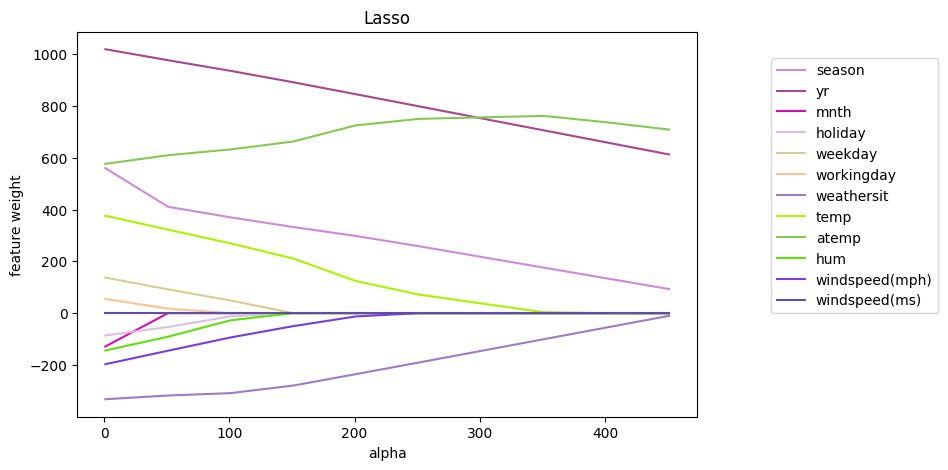

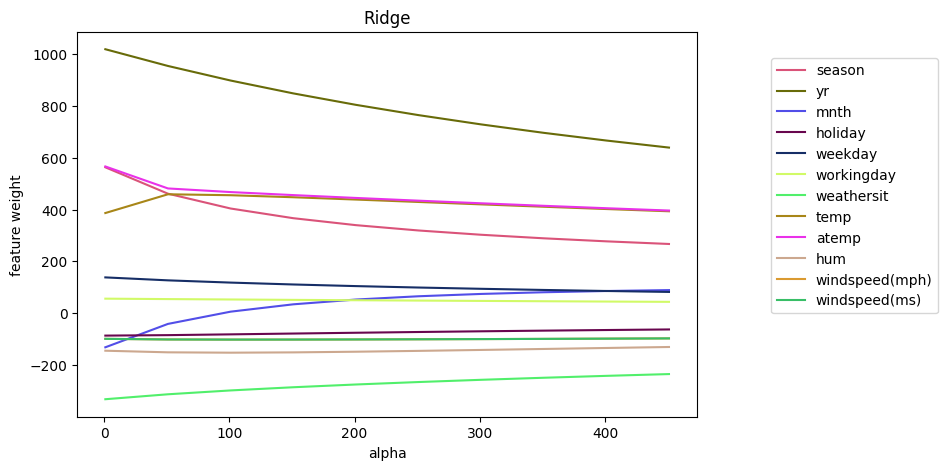

In [14]:
plt.figure(figsize=(8, 5))

for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3), )

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

plt.show()

Проанализируйте графики и дайте ответы на следующие вопросы.

1. Какой регуляризатор (Ridge или Lasso) агрессивнее уменьшает веса при одном и том же alpha?
1. Что произойдет с весами Lasso, если alpha сделать очень большим? Поясните, почему так происходит.
1. Можно ли утверждать, что `Lasso` исключает один из признаков `windspeed` при любом значении `alpha > 0`? А Ridge? Считается, что регуляризатор исключает признак, если коэффициент при нем меньше $10^{-3}$.
1. Какой из регуляризаторов подойдет для отбора неинформативных признаков?


### Задание 8

Далее будем работать с `Lasso`.

Итак, мы видим, что при изменении alpha модель по-разному подбирает коэффициенты признаков. Нам нужно выбрать наилучшее alpha.

Для этого, во-первых, нам нужна метрика качества. Будем использовать в качестве метрики сам оптимизируемый функционал метода наименьших квадратов, то есть `Mean Square Error`.

Во-вторых, нужно понять, на каких данных эту метрику считать. Нельзя выбирать `alpha` по значению MSE на обучающей выборке, потому что тогда мы не сможем оценить, как модель будет делать предсказания на новых для нее данных. Если мы выберем одно разбиение выборки на обучающую и тестовую (это называется holdout), то настроимся на конкретные "новые" данные, и вновь можем переобучиться. Поэтому будем делать несколько разбиений выборки, на каждом пробовать разные значения alpha, а затем усреднять MSE. Удобнее всего делать такие разбиения кросс-валидацией, то есть разделить выборку на $K$ часте, и каждый раз брать одну из них как тестовую, а из оставшихся блоков составлять обучающую выборку. 

Делать кросс-валидацию для регрессии в sklearn совсем просто: для этого есть специальный регрессор, __LassoCV__, который берет на вход список из alpha и для каждого из них вычисляет MSE на кросс-валидации. После обучения (если оставить параметр cv=3 по умолчанию) регрессор будет содержать переменную __mse\_path\___, матрицу размера len(alpha) x k, k = 3 (число блоков в кросс-валидации), содержащую значения MSE на тесте для соответствующих запусков. Кроме того, в переменной alpha\_ будет храниться выбранное значение параметра регуляризации, а в coef\_, традиционно, обученные веса, соответствующие этому alpha_.

Обратите внимание, что регрессор может менять порядок, в котором он проходит по alphas; для сопоставления с матрицей MSE лучше использовать переменную регрессора alphas_.

Обучите регрессор `LassoCV` на всех параметрах регуляризации из alpha. Постройте график _усредненного_ по строкам `MSE` в зависимости от `alpha` (используйте для этого функцию `create_plot`).

Выведите выбранное `alpha`, а также пары "признак-коэффициент" для обученного вектора коэффициентов.

In [15]:
def create_plot(data, title, xlabel, ylabel, figsize=None):
    size = figsize or (15, 5)
    plt.figure(figsize=size)

    x = list(map(lambda e: e[0], data))
    y = list(map(lambda e: e[1], data))
    plt.plot(x, y)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.grid()
    plt.show()

In [16]:
#Обучите регрессор LassoCV на всех параметрах регуляризации из alpha.

from sklearn.linear_model import LassoCV

alphas = np.arange(1, 100, 5)

regressor = LassoCV(alphas=alphas,cv=3).fit(X, y)

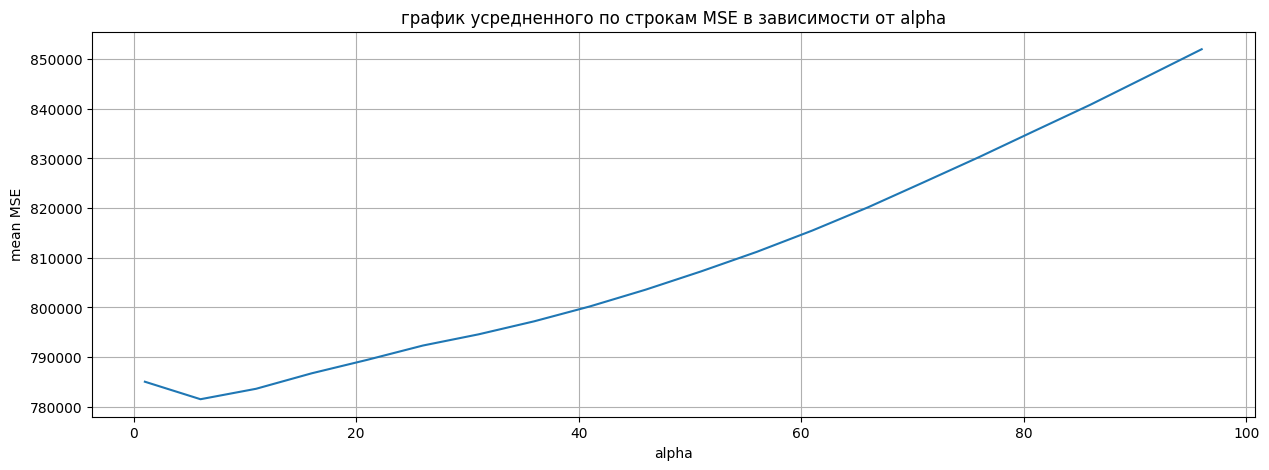

-------------------------------------------
|Alpha = 6                                |
-------------------------------------------
|feature             |coef                |
-------------------------------------------
|season              |532.0189828413535   |
|yr                  |1015.0602226430595  |
|mnth                |-100.03952614356629 |
|holiday             |-83.29395987529904  |
|weekday             |132.50446549095795  |
|workingday          |51.557085614073735  |
|weathersit          |-330.5598567399817  |
|temp                |370.67985503003405  |
|atemp               |581.396931065498    |
|hum                 |-140.00740550068844 |
|windspeed(mph)      |-191.77140847135036 |
|windspeed(ms)       |-2.6854702314758792e-08|
-------------------------------------------


In [24]:
#Постройте график усредненного по строкам MSE в зависимости от alpha (используйте для этого функцию create_plot).

#усредненного по строкам MSE
mean_mses = np.mean(regressor.mse_path_, axis=1)

#list of alphas
my_alphas = regressor.alphas_

# data for function create_plot
data=list(zip(my_alphas, mean_mses))

#график
create_plot(data=data, title='график усредненного по строкам MSE в зависимости от alpha',
            xlabel = 'alpha', ylabel='mean MSE', figsize=None)


# Выведите выбранное alpha, а также пары "признак-коэффициент" для обученного вектора коэффициентов


print('-'*43)
print('|Alpha = {:<33}|'.format(regressor.alpha_))
print('-'*43)
print('|{:<20}|{:<20}|'.format('feature', 'coef'))
print('-'*43)

for feature, coef in list(zip(df.columns, regressor.coef_)):
    print('|{:<20}|{:<20}|'.format(feature, coef)) 
print('-'*43)



Итак, мы выбрали некоторый параметр регуляризации. Давайте посмотрим, какие бы мы выбирали alpha, если бы делили выборку только один раз на обучающую и тестовую, то есть рассмотрим траектории MSE, соответствующие отдельным блокам выборки.

### Задание 9

Выведите значения `alpha`, соответствующие минимумам `MSE` на каждом разбиении (то есть по столбцам).
На трех отдельных графиках визуализируйте столбцы `mse_path_`.


Alphas with minimum MSE:
Alpha = 6, MSE = 733725.7604052245
Alpha = 1, MSE = 799433.1673691699
Alpha = 51, MSE = 796979.8955193633


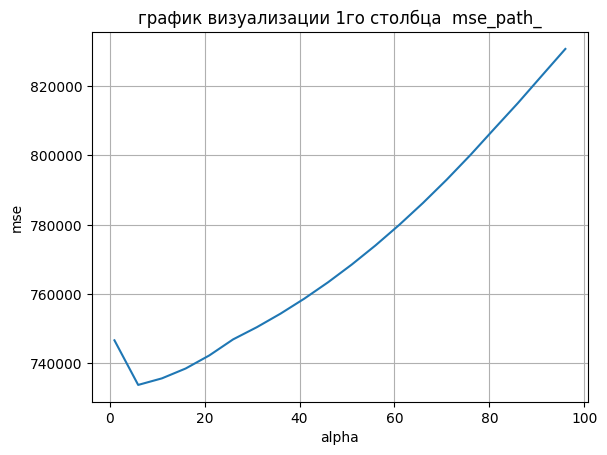

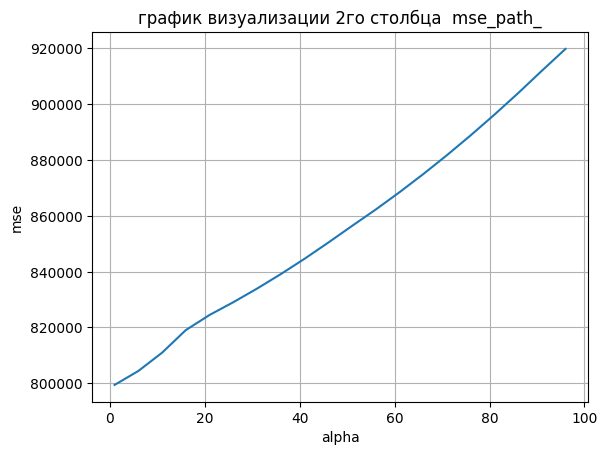

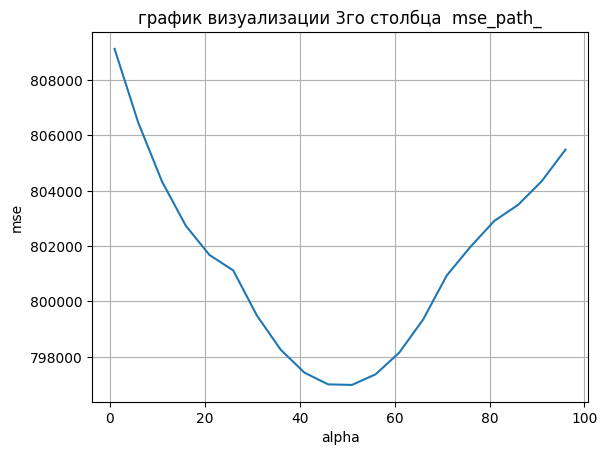

In [54]:
#Выведите значения alpha, соответствующие минимумам MSE на каждом разбиении (то есть по столбцам)

min_mses = np.min(regressor.mse_path_, axis=0)

min_mses_i = np.argmin(regressor.mse_path_, axis=0)


print('Alphas with minimum MSE:')

print(f'Alpha = {regressor.alphas_[min_mses_i[0]]}, MSE = {min_mses[0]}')
print(f'Alpha = {regressor.alphas_[min_mses_i[1]]}, MSE = {min_mses[1]}')
print(f'Alpha = {regressor.alphas_[min_mses_i[2]]}, MSE = {min_mses[2]}')


#На трех отдельных графиках визуализируйте столбцы mse_path_
for i in range (regressor.mse_path_.shape[1]):
    

    x = regressor.alphas_
    y = regressor.mse_path_[:, i]
    
    plt.plot(x, y)

    plt.title(f'график визуализации {i+1}го столбцa  mse_path_')
    plt.xlabel('alpha')
    plt.ylabel('mse')

    plt.grid()
    plt.show()


На каждом разбиении оптимальное значение `alpha` свое, и ему соответствует большое MSE на других разбиениях. Получается, что мы настраиваемся на конкретные обучающие и контрольные выборки. При выборе `alpha` на кросс-валидации мы выбираем нечто "среднее", что будет давать приемлемое значение метрики на разных разбиениях выборки. 

### Задание 10

Наконец, как принято в анализе данных, давайте проинтерпретируем результат. Ответьте на следующие вопросы.

#### Вопрос 1

В последней обученной модели выберите 4 признака с наибольшими (положительными) коэфициентами (и выпишите их), посмотрите на визуализации зависимостей `cnt` от этих признаков, которые мы рисовали в блоке "Знакомство с данными". Видна ли возрастающая линейная зависимость `cnt` от этих признаков по графикам? Логично ли утверждать (из здравого смысла), что чем больше значение этих признаков, тем больше людей захотят взять велосипеды? 

__Ответ:__

In [23]:
print('''Наибольшее значение коефициентов у признаков season, yr, temp, atemp.

-------------------------------------------
|feature             |coef                |
-------------------------------------------
|season              |532.0189828413535   |
|yr                  |1015.0602226430595  |
|temp                |370.67985503003405  |
|atemp               |581.396931065498    |
-------------------------------------------

На графикам видна возрастающая линейная зависимость cnt от этих признаков.
Я считаю, что увеличение значения признаков temp и atemp до некой границы приведет к тому,
что больше людей захотят взять велосипеды.
Но если значение признака emp и atemp будет слишком вісоким, то спрос снизиться.
Это видно на графике, при температуре болье 32-33 градусов, спрос снижается.

Самый большой положительный коефициент имеет признак yr.
Я думаю, что увеличение значения этого признака не обязательно приведет к поваышению спроса на велосипеды в бьудущем.
Так как сейчас нам известны данные за 2 года, мы видим, что в 2012 году (соответсвует значению 1 в датасете), вырос спрос
в спавнении с 2011 годом (значение 0).
Но данных по двум годам мало для того, чтобы утвержать,
что в последующих годах будет расти спрос на аренду с таким же динейным прогрессом.


''')


Наибольшее значение коефициентов у признаков season, yr, temp, atemp.

-------------------------------------------
|feature             |coef                |
-------------------------------------------
|season              |532.0189828413535   |
|yr                  |1015.0602226430595  |
|temp                |370.67985503003405  |
|atemp               |581.396931065498    |
-------------------------------------------

На графикам видна возрастающая линейная зависимость cnt от этих признаков.
Я считаю, что увеличение значения признаков temp и atemp до некой границы приведет к тому,
что больше людей захотят взять велосипеды.
Но если значение признака emp и atemp будет слишком вісоким, то спрос снизиться.
Это видно на графике, при температуре болье 32-33 градусов, спрос снижается.

Самый большой положительный коефициент имеет признак yr.
Я думаю, что увеличение значения этого признака не обязательно приведет к поваышению спроса на велосипеды в бьудущем.
Так как сейчас нам известны данны

#### Вопрос 2

Выберите 3 признака с наибольшими по модулю отрицательными коэффициентами (и выпишите их), посмотрите на соответствующие визуализации. Видна ли убывающая линейная зависимость? Логично ли утверждать, что чем больше величина этих признаков, тем меньше людей захотят взять велосипеды?

__Ответ:__

In [26]:
print('''

-------------------------------------------
|feature             |coef                |
-------------------------------------------
|weathersit          |-330.5598567399817  |
|hum                 |-140.00740550068844 |
|windspeed(mph)      |-191.77140847135036 |
-------------------------------------------

Признак weathersit имеет самое большое отрицательное значение по модулю.
Шкала weathersit - это оценка благоприятности погоды от 1 (чистый, ясный день) до 4 (ливень, туман).
На графике виджна линейная зависимость от этогог признака, чем больше оценка,
тем меньше количество жделающий аредовать велосипед.

По шкалам hum(влажность) и windspeed(скорость ветра) также видна линейная отрицательная зависимость.
Чем больше величина этих признаков, тем меньше людей захотят взять велосипеды. 
''')



-------------------------------------------
|feature             |coef                |
-------------------------------------------
|weathersit          |-330.5598567399817  |
|hum                 |-140.00740550068844 |
|windspeed(mph)      |-191.77140847135036 |
-------------------------------------------

Признак weathersit имеет самое большое отрицательное значение по модулю.
Шкала weathersit - это оценка благоприятности погоды от 1 (чистый, ясный день) до 4 (ливень, туман).
На графике виджна линейная зависимость от этогог признака, чем больше оценка,
тем меньше количество жделающий аредовать велосипед.

По шкалам hum(влажность) и windspeed(скорость ветра) также видна линейная отрицательная зависимость.
Чем больше величина этих признаков, тем меньше людей захотят взять велосипеды. 



#### Вопрос 3

Выпишите признаки с коэффициентами, близкими к нулю (< 1e-3). Как вы думаете, почему модель исключила их из модели (вновь посмотрите на графики)? Верно ли, что они никак не влияют на спрос на велосипеды?

__Ответ:__

In [27]:
print('''
----------------------------------------------
|feature             |coef                   |
----------------------------------------------
|windspeed(ms)       |-2.6854702314758792e-08|
----------------------------------------------

Моджель занулила шкалу windspeed(ms), так она полностью дублировала данные по шкале windspeed(mph).


''')


----------------------------------------------
|feature             |coef                   |
----------------------------------------------
|windspeed(ms)       |-2.6854702314758792e-08|
----------------------------------------------

Моджель занулила шкалу windspeed(ms), так она полностью дублировала данные по шкале windspeed(mph).





### Заключение
Итак, мы посмотрели, как можно следить за адекватностью линейной модели, как отбирать признаки и как грамотно, по возможности не настраиваясь на какую-то конкретную порцию данных, подбирать коэффициент регуляризации. 

Стоит отметить, что с помощью кросс-валидации удобно подбирать лишь небольшое число параметров (1, 2, максимум 3), потому что для каждой допустимой их комбинации нам приходится несколько раз обучать модель. Такой процесс занимает много времени, особенно если нужно обучаться на больших объемах данных.